<a href="https://colab.research.google.com/github/YATABARE-Cheikna-Amala/Projet_statistique_ENSAI/blob/main/OT_scOmics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Transport for single-cell omics

This Jupyter Notebook will walk you trough the code to replicate the experiments from our research on applying OT as a loss function in between single-cell omics data. [Bioinformatics paper](https://academic.oup.com/bioinformatics/article/38/8/2169/6528312).

The code is designed to be run on GPU. If you do not have access to a GPU you may want to use a free Google Colab instance to run this notebook.

## Imports

Uncomment this if running on Google Colab

In [ ]:
# !git clone https://github.com/ComputationalSystemsBiology/OT-scOmics.git
# !pip install scanpy
# !pip install leidenalg
# !pip install otscomics

General libraries to load data, do computations and make plots.

In [ ]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

Function to compute pairwise distance matrices for various functions (e.g. euclidean, cosine ...).

In [ ]:
from scipy.spatial.distance import cdist

Clustering models used for evaluation.

In [ ]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

Metrics used for scoring.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

Library `tqdm` makes pretty progress bars.

In [ ]:
from tqdm import tqdm

Our library to compute the OT distance matrix.

In [ ]:
import otscomics

Scanpy and AnnData container.

In [ ]:
import scanpy as sc
import anndata as ad

## Load preprocessed data

We provide preprocessed data as compressed csv files, with features as rows and cell as columns. The target classes (cell type or cell line) are given in the column name.

In [ ]:
# Load the data.
import pandas as pd

url = "https://raw.githubusercontent.com/cantinilab/OT-scOmics/main/data/liu_scrna_preprocessed.csv.gz"


data = pd.read_csv(url, index_col=0)
data.head()

#data = pd.read_csv('OT-scOmics/data/liu_scrna_preprocessed.csv.gz', index_col=0)

,Cell_1_HCT,Cell_2_HCT,Cell_3_HCT,Cell_4_HCT,Cell_5_HCT,Cell_6_HCT,Cell_7_HCT,Cell_8_HCT,Cell_9_HCT,Cell_10_HCT,...,Cell_197_K562,Cell_198_K562,Cell_199_K562,Cell_200_K562,Cell_201_K562,Cell_202_K562,Cell_203_K562,Cell_204_K562,Cell_205_K562,Cell_206_K562
rownames,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,4.754888,6.918863,5.807355,6.906891,6.599913,7.266787,6.857981,7.087463,7.179909,6.629357,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000457,6.584963,5.954196,7.209453,1.000000,5.209453,5.700440,7.209453,7.055282,2.321928,4.000000,...,6.539159,5.087463,0.000000,5.906891,3.906891,0.000000,6.000000,6.741467,3.906891,1.000000
ENSG00000000460,5.807355,6.087463,7.679480,1.000000,6.988685,7.294621,7.276124,6.988685,1.000000,6.339850,...,5.700440,3.169925,0.000000,4.000000,6.599913,1.000000,4.392317,6.942515,5.459432,4.247928
ENSG00000000971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.781360,6.285402,8.243174,8.134426,7.857981,7.507795,8.169925,7.794416,8.189825,8.169925
ENSG00000001084,0.000000,3.584963,7.629357,1.000000,0.000000,6.741467,3.459432,6.129283,7.312883,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.584963,0.000000,0.000000,4.906891,0.000000


In [ ]:
# Retrieve the clusters.
clusters = np.array([col.split('_')[-1] for col in data.columns])
idx = np.argsort(clusters) # Sorted indices (for visulization)
clusters[:10]

array(['HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT', 'HCT',
       'HCT'], dtype='<U4')

Les lignes correspondent au Genes que nous etudions, les collones representent les cellules. On selectionne ici les 1000 les plus variables dans le single cells, on calcule l'ecart typ de chaque ligne avant de faire la selection, -1  dans le slicing pour passer de croissant a decroissant car argsort passe du plus grand au plus petit.

In [ ]:
# Display unique clusters.
np.unique(clusters)

array(['HCT', 'Hela', 'K562'], dtype='<U4')

In [ ]:
data = data.iloc[np.argsort(data.std(1))[::-1][:1_000]]
data.head()

,Cell_1_HCT,Cell_2_HCT,Cell_3_HCT,Cell_4_HCT,Cell_5_HCT,Cell_6_HCT,Cell_7_HCT,Cell_8_HCT,Cell_9_HCT,Cell_10_HCT,...,Cell_197_K562,Cell_198_K562,Cell_199_K562,Cell_200_K562,Cell_201_K562,Cell_202_K562,Cell_203_K562,Cell_204_K562,Cell_205_K562,Cell_206_K562
rownames,,,,,,,,,,,,,,,,,,,,,
ENSG00000131016,9.204571,9.507795,9.632995,9.546894,9.596190,9.529431,9.535275,9.541097,9.411511,9.599913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000164951,8.317413,8.294621,8.219169,8.055282,8.280771,7.845490,8.276124,8.076816,8.092757,8.219169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000057019,8.784635,8.794416,8.430453,8.721099,8.584963,8.625709,8.658211,8.791163,8.550747,8.184875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000144824,8.614710,8.891784,8.027906,7.965784,7.857981,9.025140,8.539159,8.839204,8.707359,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000184254,8.124121,7.988685,8.144658,8.044394,8.092757,8.016808,7.948367,8.209453,8.144658,7.741467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Une fois cela fait, on procède ensuite a une conversion de la base de données des 1000 cellules les plus variables en Anndata, données annotés pour l'analyse single cell.

Converting the dataset to an AnnData for the rest of the analysis.

In [ ]:
adata = ad.AnnData(data.T)
adata.obs['cell_line'] = clusters
adata.obs.head()

,cell_line
Cell_1_HCT,HCT
Cell_2_HCT,HCT
Cell_3_HCT,HCT
Cell_4_HCT,HCT
Cell_5_HCT,HCT


## Compute distance matrix

In this section we will compute distance matrices between cells using both Optimal Transport and the Euclidean distance.

### Compute baseline distance matrix

Let us start by computing the euclidean distance matrix. You may change the following line of code using `cityblock`, `cosine`, `correlation` or any Scipy-compatible distance.

On calcule la distance entre chaque point de deux a deux, le paiwise(que c'est beau) avec la formule de la distance euclidenne que nous connaisons parfaitement.
Ensuite on effectue une normalisation pour les ramener tous a une echelle entre 0 et 1.

In [ ]:
# Replace `euclidean` with any scipy distance metric.
D_eu = cdist(adata.X, adata.X, metric='euclidean')
D_eu /= D_eu.max()
D_eu.shape

(206, 206)

Displaying the distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of close distances.

On peut deja apercevoir ici l'apparimention un peu nette des clusters definis avec la distance euclidienne comme permettant de mesurer les distances entre les cellules.

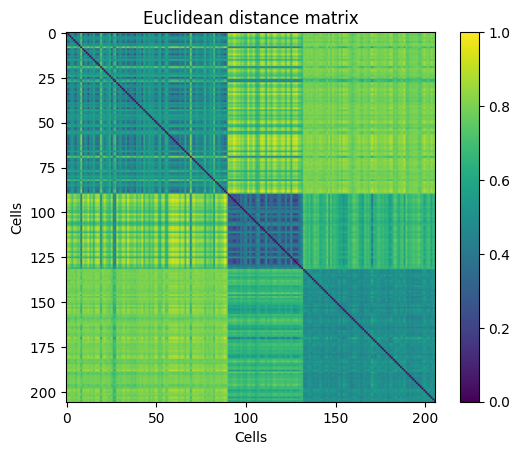

In [ ]:
plt.imshow(D_eu[idx][:,idx])
plt.title('Euclidean distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

### Compute OT distance matrix

Now on the OT distance matrix. We first need to normalize cells (divide columns by their sum). This is because Optimal Transport works on probability distributions. We then compute a cost matrix (you may change `cosine` by another function) and the associated OT distance matrix.

OT:
- normalisation parce que l'OT utilise les probabilités
- pour la matrice de cout nous utilisons ici la cosinus on peut la remplacer par une autre fonction de distance

In [ ]:
# Per-cell normalization (mandatory)
data_norm = adata.X.T.astype(np.double)
data_norm /= data_norm.sum(0)
# Add a small value to avoid numerical errors
data_norm += 1e-9 # le fameux epsillon du Shinkorn
data_norm /= data_norm.sum(0)
data_norm

array([[1.66367080e-03, 1.65951961e-03, 1.62053692e-03, ...,
        9.99999000e-10, 9.99999000e-10, 9.99999000e-10],
       [1.50332233e-03, 1.44776865e-03, 1.38269221e-03, ...,
        9.99999000e-10, 9.99999000e-10, 9.99999000e-10],
       [1.58776989e-03, 1.53500437e-03, 1.41823602e-03, ...,
        9.99999000e-10, 9.99999000e-10, 9.99999000e-10],
       ...,
       [8.28704861e-04, 1.26507572e-03, 1.12248728e-03, ...,
        3.15680289e-04, 9.99999000e-10, 9.99999000e-10],
       [9.99999000e-10, 9.02375009e-04, 4.34863106e-04, ...,
        2.09732880e-03, 1.93640259e-03, 2.39150174e-03],
       [1.37363865e-03, 1.30055744e-03, 1.33615136e-03, ...,
        1.31635996e-03, 9.99999000e-10, 9.99999000e-10]])

In [ ]:
# Compute OT distance matrix
C = otscomics.cost_matrix(adata.X.T.astype(np.double), 'cosine')  # On peut changer le cosine par une autre distance
D_ot, errors = otscomics.OT_distance_matrix(
    data=data_norm, cost=C, eps=.1,
    dtype=torch.double, device='cuda'
)

Displaying the OT distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of low distances.

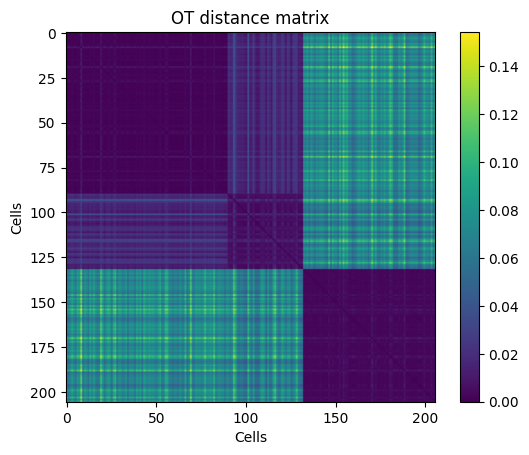

In [ ]:
plt.imshow(D_ot[idx][:,idx])
plt.title('OT distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

## Scoring

Let us compare the score for both distance matrices.

### Silhouette score

In [ ]:
print('Euclidean\t',  silhouette_score(D_eu, clusters, metric='precomputed'))
print('OT\t\t',       silhouette_score(D_ot, clusters, metric='precomputed'))

Euclidean	 0.310142677550168
OT		 0.8380411531906462


OT bat a plein de couture l'euclidien sur le silhouette score, trop fort!

### C index

In [ ]:
print('Euclidean\t',  otscomics.C_index(D_eu, clusters))
print('OT\t\t',       otscomics.C_index(D_ot, clusters))

Euclidean	 0.034578119156775076
OT		 0.002352658128477685


### Hierarchical clustering (fixed number of clusters)

We first cluster cells based on hierarchical clustering, fixed the number of clusters to the number of classes in the ground truth.

In [ ]:
#cl = AgglomerativeClustering(affinity='precomputed', n_clusters=len(np.unique(clusters)), linkage='complete')
# dernier changement dans la fonction agglomerative
cl = AgglomerativeClustering(
    metric='precomputed',
    n_clusters=len(np.unique(clusters)),
    linkage='complete'
)

In [ ]:
print('Euclidean')
cl.set_params().fit(D_eu)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean
ARI 0.9215689106896331
NMI 0.9084054726687504
AMI 0.9075477330695366


In [ ]:
print('OT')
cl.set_params().fit(D_ot)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT
ARI 1.0
NMI 1.0
AMI 1.0


### Hiarchical clustering (number of clusters derived from silhouette)

A more realistic setting is to find the "optimal" number of clusters in an unsupervised way. We run the clustering for every number of clusters between 3 and 25, and select the clustering yielding the best silhouette score.

In [ ]:
cl = AgglomerativeClustering(metric='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_eu)
  sil.append(silhouette_score(D_eu, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_eu)

print('Euclidean,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean, 3 clusters
ARI 0.9215689106896331
NMI 0.9084054726687504
AMI 0.9075477330695366


In [ ]:
cl = AgglomerativeClustering(metric='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_ot)
  sil.append(silhouette_score(D_ot, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_ot)

print('OT,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT, 3 clusters
ARI 1.0
NMI 1.0
AMI 1.0


### A typical single-cell clustering based on Leiden

In practice, single-cell clustering is often done by computing a kNN network according to euclidean distance on PCA components, and then performing Leiden clustering on that network. Here, we compare this typical workflow with Leiden clustering on the kNN network computed directly from the OT distance matrix.

In [ ]:
#!pip install igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.7 MB/s eta 0:00:00


In [ ]:
print('PCA + euclidean + kNN + Leiden')

sc.pp.pca(adata)
sc.pp.neighbors(adata)

resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):

  sc.tl.leiden(adata, resolution=resolution)

  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)

# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)

print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

PCA + euclidean + kNN + Leiden
Iterating through resolutions...


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-199033659.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution)
100%|██████████| 20/20 [00:02<00:00,  7.51it/s]

Resolution selected by silhouette score
Resolution 0.25
ARI 0.921697966842453
NMI 0.8963498310700888
AMI 0.89537886590347
nb clusters 3


In [ ]:
#from scanpy.neighbors import _compute_connectivities_umap as conn_umap
import scanpy as sc

In [ ]:
print('OT + kNN + Leiden')

# Not used, just creates objects (some useless computations here...)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

#knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(
 # D_ot, n_neighbors=15, metric='precomputed')

n_neighbors = 15
n_cells = D_ot.shape[0]

# Créer kNN à partir de distance pré-calculée
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
nbrs.fit(D_ot)
knn_dists, knn_indices = nbrs.kneighbors(D_ot)

#adata.obsp['distances'], adata.obsp['connectivities'] = conn_umap(
#    knn_indices,
#    knn_dists,
 #   adata.shape[0],
 #   15,
#)
n_cells = adata.shape[0]
connectivities = np.zeros((n_cells, n_cells))
for i in range(n_cells):
    connectivities[i, knn_indices[i]] = 1
    connectivities = csr_matrix(connectivities)
distances = csr_matrix(knn_dists)
adata.obsp['connectivities'] = connectivities
adata.obsp['distances'] = distances

resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
  sc.tl.leiden(adata, resolution=resolution)
  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)

# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)

print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

OT + kNN + Leiden


/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


ValueError: Value passed for key 'distances' is of incorrect shape. Values of obsp must match dimensions ('obs', 'obs') of parent. Value had shape (206, 15) while it should have had (206, 206).

In [ ]:
import scanpy as sc
import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from tqdm import tqdm

n_neighbors = 15

# 1️⃣ Créer kNN et connectivité manuellement à partir de D_ot
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# kNN indices et distances
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
nbrs.fit(D_ot)
distances, indices = nbrs.kneighbors(D_ot)

# Connectivité pour Scanpy (sparse matrix)
connectivities = np.zeros(D_ot.shape)
for i in range(D_ot.shape[0]):
    connectivities[i, indices[i]] = 1
connectivities = csr_matrix(connectivities)

# Assigner à AnnData
adata.obsp['connectivities'] = connectivities
adata.obsp['distances'] = csr_matrix(distances)

# 2️⃣ Résolution Leiden
resolutions = np.linspace(0.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
    sc.tl.leiden(adata, resolution=resolution, key_added='leiden')
    labels = adata.obs['leiden'].astype(int)

    if len(np.unique(labels)) > 1:
        sils.append(silhouette_score(D_ot, labels, metric='precomputed'))
        aris.append(adjusted_rand_score(clusters, labels))
        nmis.append(normalized_mutual_info_score(clusters, labels))
        amis.append(adjusted_mutual_info_score(clusters, labels))
        n_clusters.append(len(np.unique(labels)))
    else:
        sils.append(-1)
        aris.append(-1)
        nmis.append(-1)
        amis.append(-1)
        n_clusters.append(-1)

# Meilleure résolution selon silhouette
i = np.argmax(sils)
print('Resolution selected by silhouette score')
print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])


ValueError: Value passed for key 'distances' is of incorrect shape. Values of obsp must match dimensions ('obs', 'obs') of parent. Value had shape (206, 15) while it should have had (206, 206).